In [2]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML, Image

In [1]:
import logging
import time
import numpy as np

import cflib.crtp
from cflib.crazyflie import Crazyflie
from cflib.crazyflie.syncCrazyflie import SyncCrazyflie
from cflib.crazyflie.log import LogConfig
from cflib.crazyflie.syncLogger import SyncLogger

URI = f'radio://0/1/2M'

# Only output errors from the logging framework
logging.basicConfig(level=logging.ERROR)

# log_keys = ['e_z',
#             'e_y',
#             'e_roll',
#             'e_pitch',]
log_keys = ['z',
            'y',
            'roll',
            'yaw',]
other_log_keys = []

takeoff = 1
hover = 1
land = 1
entry_count = 0

if __name__ == '__main__':
    cflib.crtp.init_drivers(enable_debug_driver=False)

    with SyncCrazyflie(URI, cf=Crazyflie(rw_cache='./cache')) as scf:
        cf = scf.cf

        lg_stab = LogConfig(name='LQR', period_in_ms=10)
        lg_data = {}

        for key in log_keys:
            lg_stab.add_variable('ctrltarget.' + key, 'float')
            lg_data[key] = []

        for key in other_log_keys:
            lg_stab.add_variable( key, 'float')
            lg_data[key.split('.')[1]] = []
            
        cf.param.set_value('kalman.resetEstimation', '1')  # will reset all states
        time.sleep(0.1)
        cf.param.set_value('kalman.resetEstimation', '0')
        time.sleep(2)
        print('Reset Kalman filter.')
            
        print('Switching to LQR!')
        cf.param.set_value('stabilizer.controller', '1')
        # for y in range(10):
        #     cf.commander.send_position_setpoint(0, 0, y / 25, 0)
        #     time.sleep(0.1)
        cf.param.set_value('stabilizer.controller', '1')  # re-initialize after each (unresetted) run
        print('Taking off!')

        # cf.param.set_value('stabilizer.controller', '5')
        with SyncLogger(scf, lg_stab) as logger:
            t_start = time.time()
            

            for log_entry in logger:
                delta_t = time.time() - t_start
                if delta_t < 0.5:
                    if takeoff == 1:
                        cf.high_level_commander.takeoff(0.5, 0.5);
                        takeoff = 0
                if 1 < delta_t < 6:
                    if hover == 1:
                        # cf.high_level_commander.go_to(0, 0, 0.5, 0, 5);
                        hover = 0
                if 6 < delta_t < 6.5:
                    if land == 1:
                        cf.high_level_commander.land(0, 0.5);
                        land = 0
                for key, value in log_entry[1].items():
                    lg_data[key.split('.')[1]].append(value)

                entry_count += 1

                if delta_t > 6.5:  # x100 data points
                    cf.high_level_commander.stop();
                    break

        print('Saving data...')
        for key in lg_data.keys():
            lg_data[key] = np.array(lg_data[key])

        np.savez('quad_data/quad_traj', **lg_data)
        
        

print('Done!') 

KeyboardInterrupt: 

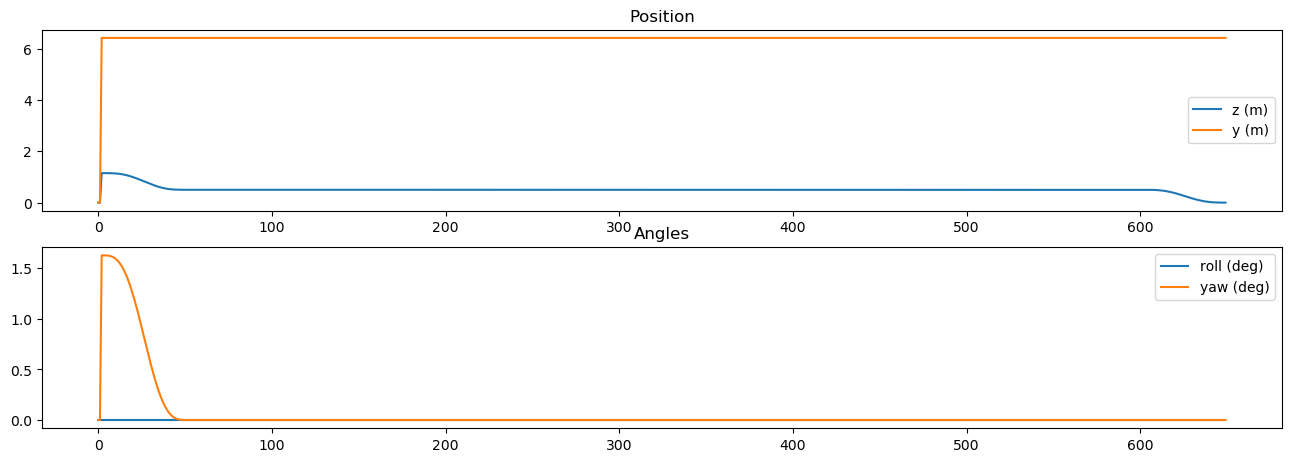

In [27]:
import os

if os.path.isfile('quad_data/quad_traj.npz'):
    npzfile = np.load('quad_data/quad_traj.npz')

    plt.rcParams["figure.figsize"] = (16,8)
    fig = plt.figure()

    ax = fig.add_subplot(311, title='Position')
    ax.plot(npzfile['z'][:entry_count], label='z (m)')
    ax.plot(npzfile['y'][:entry_count], label='y (m)')
    ax.legend()

    ax = fig.add_subplot(312, title='Angles')
    ax.plot(npzfile['roll'][:entry_count], label='roll (deg)')
    ax.plot(npzfile['yaw'][:entry_count], label='yaw (deg)')
    ax.legend()

    # ax = fig.add_subplot(313, title='Moments')
    # ax.plot(npzfile['u2_pwm'][:125] / (2 ** 15), label='M1')
    # ax.plot(npzfile['u3_pwm'][:125] / (2 ** 15), label='M2')
    # ax.legend()
else:
    print('No flight data found.')